# Import modules

In [1]:
# -*- coding: utf-8 -*-
import numpy
import random
from matplotlib import pyplot as plt
from math import exp
%matplotlib inline

# Initial parameters

In [2]:
# Population size
n = 1

# Default Time beginning
t=0

# Default trial duration
duration = 0.50 #second

# Default Time resolution
dt = 0.0001 #second 0.0001
 
# Thresholds (if from paper x200) 
Cortex_h   = 1             # -2.0
Striatum_h = 10             # 7.00    #depends of dopamine level, see below
Stn_h      = -15            #-15.0
Gpi_h      = -30             # -50.0
Thalamus_h = -15            #-15.0

# Weights
CtxTha_G = 1.7                               
StnCtx_G = 1.7                             
StrCtx_G = 1.7                               #depends on dopamine level, see below
GpiStr_G = 1.7                              
GpiStn_G = 1.7                              
ThaGpi_G = 1.7                              


# Time constants 
CtxTha_tau = 0.005 #second
StnCtx_tau = 0.020 #second "5ms for all of the synapses except synapses from cortex to STN for which it's 20ms"
StrCtx_tau = 0.005 #second
GpiStr_tau = 0.005 #second
GpiStn_tau = 0.005 #second
ThaGpi_tau = 0.005 #second

# Delays:
CtxTha_D = 0.005
StnCtx_D = 0.005
StrCtx_D = 0.006
GpiStr_D = 0.010
GpiStn_D = 0.005
ThaGpi_D = 0.005

# inputs
Cortex_I   = 0
Striatum_I = 0
Stn_I      = 0
Gpi_I      = 0
Gpi_Ie     = 0
Gpi_Ii     = 0
Thalamus_I = 0

# Activities at time t:
CtxTha_m = 0
StnCtx_m = 0
StrCtx_m = 0
GpiStr_m = 0
GpiStn_m = 0
ThaGpi_m = 0

# Activities at dt
CtxTha_dm  = 0
StrCtx_dm  = 0
StnCtx_dm  = 0
GpiStr_dm  = 0
GpiStn_dm  = 0
ThaGpi_dm  = 0

# Connectivity J

CtxTha_J = 1
StrCtx_J = 1
StnCtx_J = 1
GpiStn_J = 1
GpiStr_J = 1
ThaGpi_J = 1

# Initialization of the random generator (reproductibility !)
numpy.random.seed(1)

# Dopamine dependency : Weight & Threshold

In [3]:
# relative level of Striatal Dopamine Vs Normal (%)

#def Striatum_Dh(D):                                                  #function calculating the Striatum 
#    Striatum_h = -0.02 + 0.03 * (1-(1.1/(1+0.1*exp(-0.03*(D-100))))) #Treshold depending on the relative 
#    return Striatum_h                                                #Dopamine level D (%)

#def StrCtx_DG(D):                          #function calculating the Cortex_Striatum Weight 
#    StrCtx_G = 0.75/(1+exp(-0.09*(D-60)))  #depending on the relative Dopamine level D (%)
#    return StrCtx_G

In [4]:
#Plotting the results to check the value

#x=0
#DA_Level=[]
#Weight_Calculated=[]
#StrTh_Calculated=[]

#while x < 100:
#    x=x+1
#    DA_Level.append(x)

#    f=StrCtx_DG(x)
#    Weight_Calculated.append(f)
    
#    h=Striatum_Dh(x)
#    StrTh_Calculated.append(h)
    
#plt.figure(1)
#plt.subplot(211)
#plt.plot(DA_Level,Weight_Calculated,'b--')
#plt.ylabel('Weight')
#plt.xlabel('DA level')
#plt.grid()

#plt.subplot(212)
#plt.plot(DA_Level,StrTh_Calculated, 'r--')
#plt.ylabel('Threshold_Value')
#plt.xlabel('DA level')
#plt.grid()

#plt.show()

# Noise Function

In [5]:
#Noise level (%)
Cortex_N   =   2.00   #*200
Striatum_N =   0.20
Stn_N      =   0.20
Gpi_N      =   6.00
Thalamus_N =   0.20

In [6]:
def noise(Z, level):    #Z = size of the population
    Z = (numpy.random.uniform(0,10,Z)) # or Z = (numpy.random.uniform(-level/2,level/2,Z))*Z
    return numpy.maximum(Z,0.0)

In [7]:
#plot of noise given by the formula above

#n1 = noise(30,Cortex_N) 
#n2 = noise(30,Striatum_N) 
#n3 = noise(30,Stn_N)      
#n4 = noise(30,Gpi_N)      
#n5 = noise(30,Thalamus_N)
#plt.plot(n1,'r--',label='Cortex Noise')
#plt.plot(n2,'b--',label='Striatum Noise')
#plt.plot(n3,'k--',label='STN Noise')
#plt.plot(n4,'g--',label='GPI Noise')
#plt.plot(n5,'c--',label='Thalamus Noise')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.show()

In [8]:
#Function returning the corrected Input
def Ic(Input=0,threshold=0):
    
    if Input - threshold <= 0:
        return 0
    else:
        return (Input - threshold)

# Dynamics

In [9]:
it=0   #Number of iteration (with step dt) : a simple iteration counter

time_value=[0] #we put in a list every time to retrieve them in a gradual order

#we put in a list every value of activity to retrieve them in a time order; easy way to substract the delay
CtxTha_value=[0] 
StnCtx_value=[0]
StrCtx_value=[0]
GpiStr_value=[0]
GpiStn_value=[0]
ThaGpi_value=[0]

# Value of m(t-delta) calculated after each iteration ; for all population
m1=0    #CtxTha_m(t-CtxTha_D)=0
m2=0    #StrCtx_m(t-StrCtx_D)=0
m3=0    #StnCtx_m(t-StnCtx_D)=0
m4=0    #GpiStn_m(t-GpiStn_D)=0
m5=0    #GpiStr_m(t-GpiStr_D)=0
m6=0    #ThaGpi_m(t-ThaGpi_D)=0

In [10]:
while t < duration:    # when the time is strictly under 1 seconde
    
    t = t+dt           #for each iteration, add (the step) dt to the time
    it += 1            #for each iteration, add 1 to the iteration counter
    
# Stock activity & time :for plotting    
    
    time_value.append(round(t,5))     #command to add every time used in a list

    CtxTha_value.append(CtxTha_m) #command to add all activities of each population in a list 
    StrCtx_value.append(StrCtx_m) #respectively ; after each iteration
    StnCtx_value.append(StnCtx_m)
    GpiStn_value.append(GpiStn_m)
    GpiStr_value.append(GpiStr_m)
    ThaGpi_value.append(ThaGpi_m) 
    
# on va recuperer la valeur de l'activité a un temps t en reprenant l'index de la valeur 
# t-delta de la liste temps et l'utiliser pour trouver la valeur m(delta) a retrancher a notre
# derniere valeure de m = m(t)
    
    p1=0 
    p2=0
    p3=0
    p4=0
    p5=0
    p6=0
    
    if t < CtxTha_D:
        p1=0  
        p3=0
        p4=0
        p6=0
    
    elif t < StrCtx_D:
        p2=0
        
    elif t < GpiStr_D:    
        p5=0
        
    elif t > CtxTha_D:    
        p1=time_value.index(round(t-CtxTha_D,5))
        p3=time_value.index(round(t-StnCtx_D,5))
        p4=time_value.index(round(t-GpiStn_D,5))
        p6=time_value.index(round(t-ThaGpi_D,5))
    elif t > StrCtx_D:
        p2=time_value.index(round(t-StrCtx_D,5))
    elif t > GpiStr_D:    
        p5=time_value.index(round(t-GpiStr_D,5))
    
    
    m1=CtxTha_value[-1]-CtxTha_value[p1]   #command to calculate the m(t-delta) value for each population;
    m2=StrCtx_value[-1]-StrCtx_value[p2]   #We substract the activity a time t with the activity a time t-delta
    m3=StnCtx_value[-1]-StnCtx_value[p3]  
    m4=GpiStn_value[-1]-GpiStn_value[p4]
    m5=GpiStr_value[-1]-GpiStr_value[p5]
    m6=ThaGpi_value[-1]-ThaGpi_value[p6]
    
    
    CtxTha_m += CtxTha_dm    # we add the activity (dm) to the global activity (m),
    StnCtx_m += StnCtx_dm    # after a step dt ; for all population
    StrCtx_m += StrCtx_dm    #stored in the list ("PopulationNames"_value)
    GpiStr_m += GpiStr_dm
    GpiStn_m += GpiStn_dm
    ThaGpi_m += ThaGpi_dm
    
    
#Update of inputs
    Cortex_I   = CtxTha_G*CtxTha_J*m1 + float(noise(1, Cortex_N))     ##+ external input
    Striatum_I = StrCtx_G*StrCtx_J*m2 + float(noise(1, Striatum_N))   ##+ external input
    Stn_I      = StnCtx_G*StnCtx_J*m3 + float(noise(1, Stn_N))        ##+ external input
    Gpi_Ie     = GpiStn_G*GpiStn_J*m4 + float(noise(1, Gpi_N))        ##+ external input
    Gpi_Ii     = -GpiStr_G*GpiStr_J*m5 + float(noise(1, Gpi_N))       ##+ external input
    Gpi_I      = GpiStn_G*GpiStn_J*m4 - GpiStr_G*GpiStr_J*m5 + float(noise(1, Gpi_N)) #+ external input
    Thalamus_I = -ThaGpi_G*ThaGpi_J*m6 + float(noise(1, Thalamus_N)) #+ external input

#Update of activities
    CtxTha_dm  = dt*(-CtxTha_m + Ic(Thalamus_I,Thalamus_h))/CtxTha_tau   ## + external input Iext
    StrCtx_dm  = dt*(-StrCtx_m + Ic(Cortex_I,Cortex_h ))/StrCtx_tau
    StnCtx_dm  = dt*(-StnCtx_m + Ic(Cortex_I,Cortex_h ))/StnCtx_tau
    GpiStr_dm  = dt*(-GpiStr_m + Ic(Striatum_I,Striatum_h))/GpiStr_tau
    GpiStn_dm  = dt*(-GpiStn_m + Ic(Stn_I,Stn_h))/GpiStn_tau
    ThaGpi_dm  = dt*(-ThaGpi_m + Ic(Gpi_I,Gpi_h))/ThaGpi_tau


# Plotting results

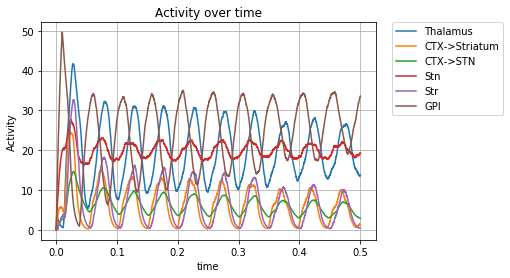

In [11]:
plt.plot(time_value,CtxTha_value,label='Thalamus')
plt.plot(time_value,StrCtx_value,label='CTX->Striatum')
plt.plot(time_value,StnCtx_value,label='CTX->STN')
plt.plot(time_value,GpiStn_value,label='Stn')
plt.plot(time_value,GpiStr_value,label='Str')
plt.plot(time_value,ThaGpi_value,label='GPI')

plt.title('Activity over time')
plt.ylabel('Activity')
plt.xlabel('time')
plt.grid()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()